# 17 · Untrained models control (CKA)

**Why this check?**  
If model–brain alignment were driven purely by architecture or low‑level statistics (not learning), untrained networks should already show the observed patterns. We therefore recomputed model–brain similarity using **untrained** vision and language models (unbiased linear CKA).

**Summary of what what we find:**

- **Vision (untrained):** Flat curves across depth; alignment confined to early visual cortex (EVC). Random conv filters already capture low‑level visual structure → same story as trained models’ first layers.  
- **Language (untrained):** Highest alignment at the input layer (token embeddings), then a monotonic drop. No architecture‑driven rise later. LOTC still shows a weak peak, consistent with tokenizer/bag‑of‑words effects (see Notebook 16). Visual areas show only tiny residual alignment (~1%).


## Imports & setup

Load paths, helpers, and set fonts. Nothing fancy here—just standard project utilities.


In [ ]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from convergence.operations import interpolate_alignment_series, unpack_scores
from convergence.figures import setup_matplotlib_fonts, plot_cbar_set
from convergence.figures_utils import add_cluster
from convergence.plotting import plot_faverage_parcelation

setup_matplotlib_fonts()

Define data paths

In [17]:
derivatives_folder = Path("../derivatives")

hcp_filename = derivatives_folder / "metadata" / "hcp.csv"
untrained_models_filename = derivatives_folder / "nsd" / "cka_untrained_models_similarity.parquet"
model_info_filename = derivatives_folder / "metadata" / "models-info.csv"
figures_folder = Path("../figures")
output_folder = figures_folder / "17_untrained_models_similarity"
output_folder.mkdir(parents=True, exist_ok=True)


## Load untrained-model results

We read the parquet with ROI×layer×model×subject CKA scores. These were computed on NSD stimuli/labels but with **random weights**.


In [14]:
df = pd.read_parquet(untrained_models_filename)
df


,layer,metric,score,n_stim,roi,subject,session,model,modality
0,0,unbiased_cka,0.016275,750,1,1,1,openlm-research_open_llama_7b_pool-avg_prompt-...,language
1,1,unbiased_cka,0.016237,750,1,1,1,openlm-research_open_llama_7b_pool-avg_prompt-...,language
2,2,unbiased_cka,0.014947,750,1,1,1,openlm-research_open_llama_7b_pool-avg_prompt-...,language
3,3,unbiased_cka,0.014304,750,1,1,1,openlm-research_open_llama_7b_pool-avg_prompt-...,language
4,4,unbiased_cka,0.013377,750,1,1,1,openlm-research_open_llama_7b_pool-avg_prompt-...,language
...,...,...,...,...,...,...,...,...,...
9917275,7,unbiased_cka,-0.000398,750,180,8,30,vit_base_patch16_clip_224.laion2b_ft_in12k_poo...,vision
9917276,8,unbiased_cka,-0.000471,750,180,8,30,vit_base_patch16_clip_224.laion2b_ft_in12k_poo...,vision
9917277,9,unbiased_cka,-0.000526,750,180,8,30,vit_base_patch16_clip_224.laion2b_ft_in12k_poo...,vision
9917278,10,unbiased_cka,-0.000475,750,180,8,30,vit_base_patch16_clip_224.laion2b_ft_in12k_poo...,vision


## Prepare data: interpolate & average

1. Select a subset of ROIs used elsewhere (EVC, VMV/PHA hub, LOTC, etc.).  
2. Filter out numerical instabilities (CKA outside [−0.001, 1]).  
3. Interpolate each model’s layer trajectory to a common depth scale and average across models within a modality (vision vs language) and across subjects.


In [44]:

hcp = pd.read_csv(hcp_filename)
selected_rois = ["V1","V2","V3","V4","V8",
                 "PHA1", "PHA2", "PHA3", "VMV1", "VMV2", "VMV3", "FFC",
                 "VVC", "V4t", "FST", "MST", "MT", "TPOJ3", "TPOJ2",
                 ]
roi_list = hcp[hcp.name.isin(selected_rois)].roi.unique()

df = pd.read_parquet(untrained_models_filename)
df = df.query("roi in @roi_list and score > -0.001 and score < 1")
df_g = df.groupby(["roi", "model", "layer", "subject"]).score.mean().reset_index()
df_interpolated = interpolate_alignment_series(df_g, groups=["subject", "roi", "model"])
df_interpolated = unpack_scores(df_interpolated)
df_interpolated = df_interpolated.rename(columns={"model": "model_name"})
df_interpolated["modality"] = df_interpolated["model_name"].str.startswith("vit_").map(
    {True: "vision", False: "language"}
)
df_interpolated = (
    df_interpolated.groupby(["subject", "roi", "modality", "layer"]).score.mean().reset_index()
)
df_interpolated
df_interpolated["depth"] = df_interpolated["layer"] / df_interpolated["layer"].max()
df_interpolated = df_interpolated.merge(hcp[["roi", "name", "area", "area_color"]], on="roi")
df_interpolated = add_cluster(df_interpolated)
df_interpolated


,subject,roi,modality,layer,score,depth,name,area,area_color,cluster
0,1,1,language,0,0.012173,0.000000,V1,Primary Visual,#1f77b4,Visual Cortex
1,1,1,language,1,0.010697,0.025641,V1,Primary Visual,#1f77b4,Visual Cortex
2,1,1,language,2,0.009801,0.051282,V1,Primary Visual,#1f77b4,Visual Cortex
3,1,1,language,3,0.009283,0.076923,V1,Primary Visual,#1f77b4,Visual Cortex
4,1,1,language,4,0.009016,0.102564,V1,Primary Visual,#1f77b4,Visual Cortex
...,...,...,...,...,...,...,...,...,...,...
12155,8,163,vision,35,0.010492,0.897436,VVC,Ventral Visual,#ff7f0e,Other
12156,8,163,vision,36,0.010458,0.923077,VVC,Ventral Visual,#ff7f0e,Other
12157,8,163,vision,37,0.010413,0.948718,VVC,Ventral Visual,#ff7f0e,Other
12158,8,163,vision,38,0.010368,0.974359,VVC,Ventral Visual,#ff7f0e,Other


## Plot depth curves

Line plots (±SE across subjects) for six representative ROIs:

- **Vision untrained:** nearly horizontal lines at ~0.04–0.045 for V1/V2; others ~0.006. No growth with depth.  
- **Language untrained:** highest at depth 0 (token layer), then decays and flattens.

These contrast with trained-model curves (see main notebook 03), where deeper layers increase alignment in semantic hubs.


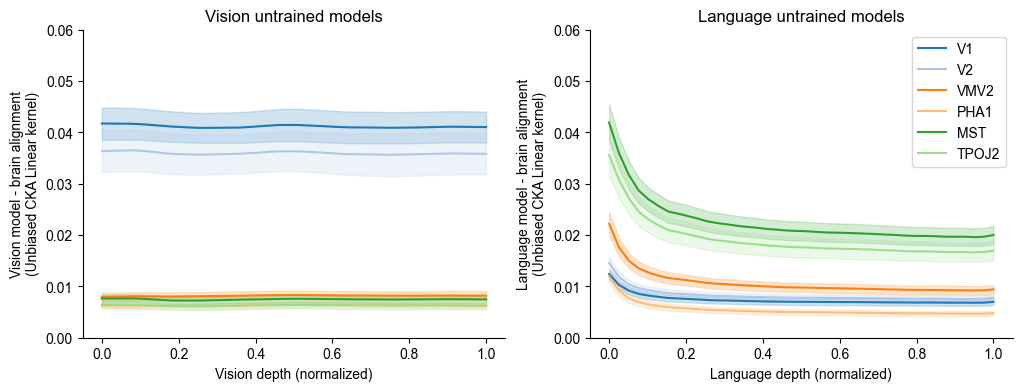

In [ ]:
hue_order = [
    "V1",
    "V2",
    "VMV2",
    "PHA1",
    "MST",
    "TPOJ2",
]
palette = df_interpolated.drop_duplicates("name").set_index("name").area_color.to_dict()


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, modality in zip(axes, ["vision", "language"]):
    sns.lineplot(
        data=df_interpolated.query("modality == @modality and name in @hue_order"),
        x="depth",
        y="score",
        hue="name",
        hue_order=hue_order,
        palette=palette,
        ax=ax,
        errorbar="se"

    )
    sns.despine(ax=ax)
    ax.legend(title="")
    ax.set_title(f"{modality.capitalize()} untrained models")
    ax.set_xlabel(f"{modality.capitalize()} depth (normalized)")
    ax.set_ylabel(f"{modality.capitalize()} model - brain alignment\n(Unbiased CKA Linear kernel)")
    ax.set_ylim(0, 0.05)
    

axes[0].legend_.remove()
filename = output_folder / "01_untrained_models_similarity.pdf"
fig.savefig(filename, bbox_inches="tight", transparent=True)

## Spatial maps (Fig. B)

We take the **max (signed) CKA** per ROI (across layers), average across subjects/models, and project to fsaverage (LH). Range is tiny (0–0.05), so interpret magnitudes cautiously.

- **Vision:** strong EVC, little elsewhere.  
- **Language:** LOTC hot spot, weak elsewhere; mirrors tokenizer map.

In [82]:
df_spatial = pd.read_parquet(untrained_models_filename)
df_spatial = df_spatial.query("score > -0.001 and score < 1") # Instability of cka computation
df_spatial["abs_score"] = df_spatial["score"].abs()
# Sort by absolute score and get the max per roi (signed)
df_spatial = df_spatial.sort_values("abs_score", ascending=False)
df_spatial = df_spatial.drop_duplicates(["roi", "subject", "model", "session"], keep="first")
df_spatial = df_spatial.groupby(["roi", "model", "subject", "modality"]).score.mean().reset_index()
df_spatial = df_spatial.groupby(["roi", "modality"]).score.mean().reset_index()
hcp = pd.read_csv(hcp_filename)
hcp = hcp[["roi", "name", "mne_name"]]
df_spatial = df_spatial.merge(hcp, on="roi")
print(df_spatial.groupby("modality").score.describe())
df_spatial


          count      mean       std       min       25%       50%       75%  \
modality                                                                      
language  180.0  0.006101  0.007368  0.001216  0.001839  0.003075  0.006092   
vision    180.0  0.005633  0.005051  0.002219  0.003369  0.004098  0.006146   

               max  
modality            
language  0.041982  
vision    0.043881  


,roi,modality,score,name,mne_name
0,1,language,0.012562,V1,L_V1_ROI-lh
1,1,vision,0.043881,V1,L_V1_ROI-lh
2,2,language,0.041982,MST,L_MST_ROI-lh
3,2,vision,0.008508,MST,L_MST_ROI-lh
4,3,language,0.004374,V6,L_V6_ROI-lh
...,...,...,...,...,...
355,178,vision,0.003435,PI,L_PI_ROI-lh
356,179,language,0.001638,a32pr,L_a32pr_ROI-lh
357,179,vision,0.002515,a32pr,L_a32pr_ROI-lh
358,180,language,0.001675,p24,L_p24_ROI-lh


In [ ]:
views = ["lateral", "medial", "ventral", "caudal"]
modalities = ["vision", "language"]
vmax = 0.05
for modality in modalities:
    df_spatial_modality = df_spatial.query("modality == @modality")    
    brain = plot_faverage_parcelation(
        df_spatial_modality,
        cmap="RdBu_r",
        normalize=(-vmax, vmax),
        default_color="lightgrey",
        default_value=None,
        hemisphere="lh", # Left to show joined
    )
    for view in views:
        brain.show_view(view)
        filename = output_folder / f"02_untrained_models_spatial_{modality}_{view}_{vmax:.2f}_cka.png"
        brain.save_image(filename, mode="rgba")
    brain.close()

## Preview montage

Convenience panel showing four views × two modalities. Purely visual check.


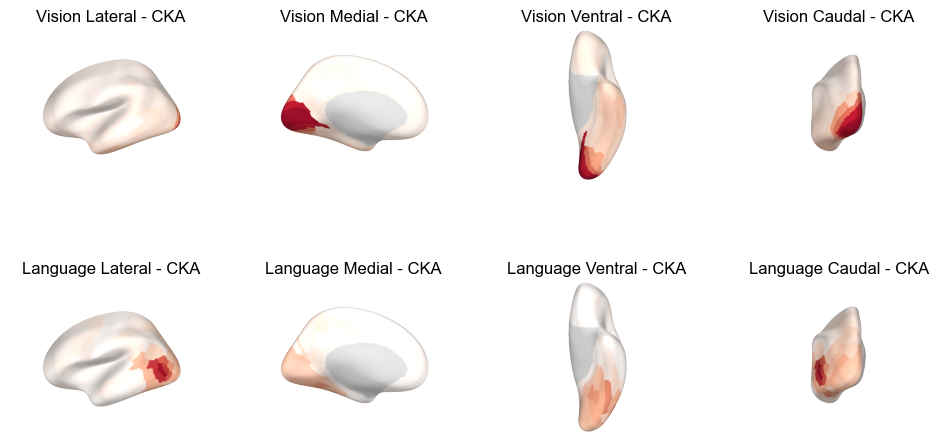

In [90]:
fig, axes = plt.subplots(len(modalities), len(views), figsize=(12, 6))

for i, modality, in enumerate(modalities):
    for j, view in enumerate(views):
        ax = axes[i, j]
        filename = output_folder / f"02_untrained_models_spatial_{modality}_{view}_{vmax:.2f}_cka.png"
        img = plt.imread(filename)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{modality.capitalize()} {view.capitalize()} - CKA")

## Colourbar export

Save a stand‑alone CKA colourbar (0–0.05) for figure assembly.


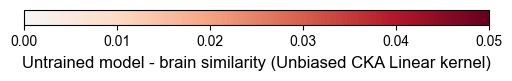

In [93]:
title = "Untrained model - brain similarity (Unbiased CKA Linear kernel)"
filename = output_folder / "02_cka_colorbar.pdf"
plot_cbar_set(title=title, filename=filename, vmax=vmax, vmin=0, locator=0.01)

## Take‑home

- **Training matters for high‑level alignment.** Vision architectures alone give you low‑level EVC structure; language architectures alone do not produce LOTC‑like alignment beyond what the tokenizer already injects.  
- The results dovetail with the tokenizer analysis: LOTC effects stem from token statistics, not contextualised language features in random weights.  
- We excluded this control from the main paper due to space and because it reiterates points already supported by other analyses—but it’s kept here for completeness.


